In [ ]:
! pip uninstall lightgbm -y

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3


In [ ]:
!pip install lightgbm --install-option=--gpu

/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5 MB 4.4 MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
    Running setup.py install for lightgbm ... done


In [1]:
import lightgbm as lgb

# 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
cd '../gdrive/MyDrive/SSAC/3조'

/gdrive/.shortcut-targets-by-id/15_BxZVEQYCdGCGiQ5nexpWPc1cgHVe4w/3조


# CTR 예측 모델링

### 라이브러리 로드

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

In [5]:
import joblib
import os

In [6]:
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [7]:
import warnings
warnings.filterwarnings('ignore')

## 학습 데이터 불러오기

In [86]:
df = pd.read_csv('data/merged_data_notext.csv')
df.head()

,content_id,bid_price,imp_id,imp_time,label,user_id,view_time,adv_id,content_name,content_price,content_used,content_cat_1,content_cat_2,content_cat_3,content_emergency_count,content_comment_count,content_views,content_likes,content_b_pay,content_delivery_fee,content_place,content_status,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,viewer_gender,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count,content_img_url
0,137078818,50,99d1612dded122458e99,16:48:41.780,1,1728109,16:56:46.013,12851816,#당일발송#아이폰SE2 64G/128G 대량판매 등급별초특가!,250000,1,전자제품,600700,600700001,1,4,25583,817,0,NaN,NaN,삭제됨,2131,5285,247,4525,542,739,496,0,0,11,1,30,5,0,0,0,0,https://media.bunjang.co.kr/product/137078818_...
1,137078818,50,971a612de1a50ebc01ce,17:00:45.805,0,1728109,NaN,12851816,#당일발송#아이폰SE2 64G/128G 대량판매 등급별초특가!,250000,1,전자제품,600700,600700001,1,4,25583,817,0,NaN,NaN,삭제됨,2131,5285,247,4525,542,739,496,0,0,11,1,30,5,0,0,0,0,https://media.bunjang.co.kr/product/137078818_...
2,137078818,50,971a612de24b0ebe9859,17:03:49.363,0,1728109,NaN,12851816,#당일발송#아이폰SE2 64G/128G 대량판매 등급별초특가!,250000,1,전자제품,600700,600700001,1,4,25583,817,0,NaN,NaN,삭제됨,2131,5285,247,4525,542,739,496,0,0,11,1,30,5,0,0,0,0,https://media.bunjang.co.kr/product/137078818_...
3,137078818,50,9919612de22422461f9b,17:02:48.690,0,1728109,NaN,12851816,#당일발송#아이폰SE2 64G/128G 대량판매 등급별초특가!,250000,1,전자제품,600700,600700001,1,4,25583,817,0,NaN,NaN,삭제됨,2131,5285,247,4525,542,739,496,0,0,11,1,30,5,0,0,0,0,https://media.bunjang.co.kr/product/137078818_...
4,137078818,50,998c612de1e300aa29bc,17:01:51.038,0,1728109,NaN,12851816,#당일발송#아이폰SE2 64G/128G 대량판매 등급별초특가!,250000,1,전자제품,600700,600700001,1,4,25583,817,0,NaN,NaN,삭제됨,2131,5285,247,4525,542,739,496,0,0,11,1,30,5,0,0,0,0,https://media.bunjang.co.kr/product/137078818_...


In [58]:
df.columns

Index(['content_id', 'bid_price', 'imp_id', 'imp_time', 'label', 'user_id',
       'view_time', 'adv_id', 'content_name', 'content_price', 'content_used',
       'content_cat_1', 'content_cat_2', 'content_cat_3',
       'content_emergency_count', 'content_comment_count', 'content_views',
       'content_likes', 'content_b_pay', 'content_delivery_fee',
       'content_place', 'content_status', 'adv_follower_count', 'adv_grade',
       'adv_item_count', 'adv_views', 'adv_review_count', 'adv_comment_count',
       'adv_pay_count', 'adv_parcel_post_count', 'adv_transfer_count',
       'adv_chat_count', 'viewer_gender', 'viewer_age',
       'viewer_following_count', 'viewer_pay_count',
       'viewer_parcel_post_count', 'viewer_transfer_count',
       'viewer_chat_count', 'content_img_url'],
      dtype='object')

In [59]:
df['content_emergency_count'].describe()

count    735694.000000
mean          1.559269
std          11.270738
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         273.000000
Name: content_emergency_count, dtype: float64

In [60]:
df['viewer_age'].value_counts()

0      69636
25     20780
22     19652
26     19441
42     19353
       ...  
93         7
100        4
111        4
96         1
115        1
Name: viewer_age, Length: 93, dtype: int64

# EDA

## 전처리 함수 정의

In [87]:
categorical = [
    'viewer_gender',  
    'content_used', 
    'content_cat_2']
     
    # 'content_cat_2', 
    # 'content_cat_3']

In [88]:
continuous = [
    'bid_price', 
    'content_price',
    'content_emergency_count',
    'content_comment_count',     
    'content_views',       
    'content_likes',    
    'adv_follower_count',
    'adv_grade',       
    'adv_item_count',         
    'adv_views',        
    'adv_review_count', 
    'adv_comment_count',
    'adv_pay_count',
    'adv_parcel_post_count', 
    'adv_transfer_count', 
    'adv_chat_count',
    'viewer_age',
    'viewer_following_count',
    'viewer_pay_count',
    'viewer_parcel_post_count', 
    'viewer_transfer_count',
    'viewer_chat_count']

In [89]:
features = categorical + continuous

In [90]:
def process_missing_values(df):
    for categorical_col in categorical:
        df[categorical_col] = df[categorical_col].astype(str)
        df[categorical_col] = df[categorical_col].fillna('0')
        df[categorical_col] = preprocessing.LabelEncoder().fit_transform(df[categorical_col])

    for continuous_col in continuous:
        df[continuous_col] = df[continuous_col].fillna(0)

    return df

## 전처리 진행

In [91]:
df['title_len'] = df['content_name'].apply(lambda x: len(x))

In [92]:
df = process_missing_values(df)

### 평균 CTR 계산

In [67]:
grouped_label = df.groupby('label').size()
average_ctr = float(grouped_label[1]/grouped_label.sum())
average_ctr

0.03200107653453746

In [68]:
features.append('title_len')

## Train/Test 데이터 나누기 (8:2)

In [95]:
train_test_df = df[['label'] + features]
train, test = train_test_split(train_test_df, test_size = 0.2, random_state=47)

X_train = train[features]
y_train = train['label']

X_test = test[features]
y_test = test['label']

In [96]:
X_train.head()

,viewer_gender,content_used,content_cat_2,bid_price,content_price,content_emergency_count,content_comment_count,content_views,content_likes,adv_follower_count,adv_grade,adv_item_count,adv_views,adv_review_count,adv_comment_count,adv_pay_count,adv_parcel_post_count,adv_transfer_count,adv_chat_count,viewer_age,viewer_following_count,viewer_pay_count,viewer_parcel_post_count,viewer_transfer_count,viewer_chat_count
161683,1,1,64,50,375000,0,0,593,19,2131,5285,247,4525,542,739,496,0,0,11,41,0,0,0,0,0
665614,2,0,9,50,128000,0,0,78,3,949,637,728,2087,65,3,60,0,1,0,30,54,1,100,0,0
680267,2,0,10,50,47000,0,0,138,8,448,225,581,373,23,4,38,0,0,0,51,1,32,0,7,0
623185,0,0,49,60,280000,3,244,21926,683,7144,10000,85,357189,1030,948,282,0,437,4,63,8,0,0,0,0
329998,0,1,69,50,880000,0,0,406,2,357,546,403,1507,58,124,130,0,2,11,0,0,0,0,0,0


# LightGBM 학습

In [97]:
from sklearn.model_selection import GridSearchCV

In [98]:
cd

/root


In [99]:
from lightgbm import LGBMClassifier

## CV

평가함수 정의

In [100]:
from sklearn.metrics import roc_auc_score

def get_rig(train_y, test_y, pred):
    avg_ctr = average_ctr
    prior = log_loss(train_y, [avg_ctr]*len(train_y))

    classifier = log_loss(test_y, pred)

    rig = (prior - classifier) / prior
    return rig


params 설정

In [101]:
#   'max_depth' : [10, 15, 20, 25, 30],
#   'num_leaves': [31, 63, 127], 
#   'learning_rate': [0.1, 0.05, 0.01, 0.005], 
p_list = []
for md in [5, 6, 7, 8, 9, 10, 11, 12]:
    for nl in [31, 50, 63, 100, 127]:
        for lr in [0.1, 0.05, 0.01]:
            p_list.append((lr, md, nl))
len(p_list)

120

In [102]:
from lightgbm import LGBMClassifier

In [103]:
import lightgbm as lgb

In [104]:
params = {'boosting_type': 'dart', 
        'metric': {'auc', 'binary_logloss'}, 
        'num_leaves': 127, 
        'max_depth': 15,
        'learning_rate': 0.1, 
        'feature_fraction': 0.9, 
        'bagging_fraction': 0.8, 
        'bagging_freq': 5, 
        'verbose': 0} 

        # train_ds = lgb.Dataset(train_X, label=train_y)
        # valid_ds = lgb.Dataset(valid_X, label=valid_y) 
model = lgb.LGBMClassifier(n_estimators=50,
    learning_rate=0.1,
    num_leaves=127,
    max_depth=15,
    zero_as_missing=True,
    n_jobs=os.cpu_count(),
    objective='binary')
print('start training')
model.fit(X_train, y_train)
print('predicting')
pred = model.predict_proba(X_test)[:,1]

print(f'auc : {roc_auc_score(y_test, pred)}, rig: {get_rig(y_train, y_test, pred)}')

start training
predicting
auc : 0.7459826620871929, rig: 0.10175507013146384


## 유저에게 보여줄 광고 후보군 생성

In [ ]:
ad_df = pd.read_csv('data/ad_new.csv')
id2name = ad_df[['content_id', 'name']].set_index('content_id').transpose().to_dict('records')[0]

In [107]:
candidate_features = [
    'bid_price', 
    'content_id',
    'content_price',
    'content_used', 
    'content_cat_1',
    'content_cat_2', 
    'content_cat_3', 
    'title_len',
    'content_emergency_count',
    'content_comment_count', 
    'content_views', 
    'content_likes',    
    'adv_follower_count', 
    'adv_grade', 
    'adv_item_count',
    'adv_views', 
    'adv_review_count', 
    'adv_comment_count', 
    'adv_pay_count',
    'adv_parcel_post_count', 
    'adv_transfer_count', 
    'adv_chat_count']

### Input 데이터 생성 및 전처리

In [108]:
user_demo = pd.DataFrame({
    'viewer_gender': [1],
    'viewer_age': [80],
    'viewer_following_count': [10],
    'viewer_pay_count': [3],
    'viewer_parcel_post_count': [5],
    'viewer_transfer_count': [1],
    'viewer_chat_count': [1]
})

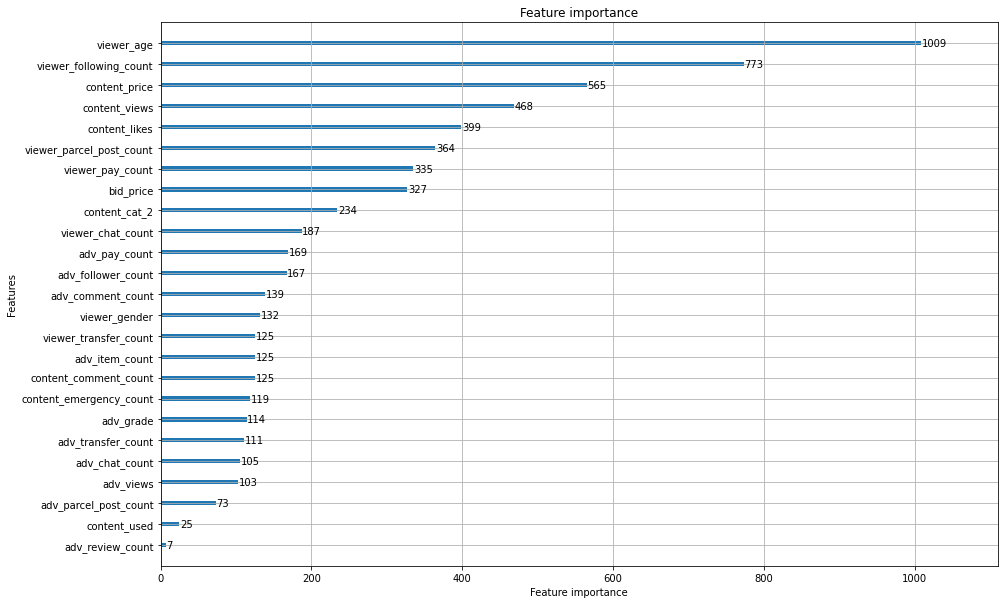

In [109]:
fig, ax = plt.subplots(figsize=(15, 10))
lgb.plot_importance(model, ax=ax)

In [110]:
from IPython.display import HTML, display

In [151]:
html = ""

for i in range(4):
    user_demo = pd.DataFrame({
    'viewer_gender': [1],
    'viewer_age': [20*i],
    'viewer_following_count': [10],
    'viewer_pay_count': [3],
    'viewer_parcel_post_count': [5],
    'viewer_transfer_count': [1],
    'viewer_chat_count': [1]
    })
    
    candidates = df.drop_duplicates(['content_id'], keep='first')

    candidates_df = candidates[candidate_features]
    candidates_df.reset_index(drop=True, inplace=True)
    candidates_df['content_img_url'] = candidates_df['content_id'].apply(lambda x : f'https://media.bunjang.co.kr/product/{x}_...')

    # /candidates_df = candidates_df[candidates_df['bid_price']<70]

    for col in user_demo.columns:
        candidates_df[col] = user_demo[col][0]
    feature_df = candidates_df
    feature_df = process_missing_values(feature_df)

    feature_df = feature_df[features]
    probs = model.predict_proba(feature_df)

    candidates_df['probs'] = probs[:, 1]
    candidates_df['ecpm'] = candidates_df['bid_price'] * candidates_df['probs'] * 1000
    candidates_df.sort_values(by=['probs'], ascending=False, inplace=True)

    html += f'<li> 나이 : {20*i}살</li>'
    for idx, row in candidates_df[0:20].iterrows():
        html += f'''
            <div style="display:inline-block;min-width:150px;max-width:150px;vertical-align:top">
            
            <ul>
                <li>광고명: {id2name[row.content_id]}</li>
                <li>가격: {row.content_price}</li>
                <li>eCPM: {round(row.ecpm)}</li>
                <li>bid: {row.bid_price}</li>
                <li>prob: {round(row.probs, 4)}</li>
            </ul>
            <img src="{row.content_img_url}" style="width:150px;">
            </div>
            '''
        
display(HTML(html))

In [127]:
man30 = candidates_df.groupby('content_cat_1').mean()[['bid_price','ecpm', 'probs']]

In [142]:
man30 = man30.rename({'ecpm':'30_ecpm', 'probs':'30_probs'}, axis=1)

In [140]:
man80 = candidates_df.groupby('content_cat_1').mean()[['ecpm', 'probs']]
man80 = man80.rename({'ecpm':'80_ecpm', 'probs':'80_probs'}, axis=1)

In [146]:
df_3080 = pd.concat([man30, man80], axis=1)[['30_probs', '80_probs']]

In [150]:
df_3080.sort_values('80_probs', ascending=False) * 100

,30_probs,80_probs
content_cat_1,,
지역 서비스,1.142728,13.346373
유아동/출산,2.004901,10.130514
기타,2.850863,4.398361
전자제품,3.148242,3.978925
남성 의류,1.935938,3.883414
남성 악세사리,4.181189,3.742602
미용품,3.305073,3.685174
여성 의류,1.609839,3.528392
예술/희귀/수집품,0.983383,2.741285
